# 1. Setup

* Import the required libraries

In [119]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

%matplotlib inline

* Read in the training data

In [54]:
data = pd.read_csv('./data/train_Data.csv.csv_fixed')

print('Read in training data. Columns: {0}, Rows: {1}'.format(data.shape[1], data.shape[0]))

Read in training data. Columns: 7, Rows: 82908


# 2. Data Exploration & Cleaning

* Print out the dataset summary

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82908 entries, 0 to 82907
Data columns (total 7 columns):
user_id     82908 non-null int64
channel     82908 non-null object
age         82908 non-null int64
os          82908 non-null object
gender      82908 non-null object
country     82908 non-null object
customer    82908 non-null int64
dtypes: int64(3), object(4)
memory usage: 4.4+ MB


* Print out a few rows

In [7]:
data.head(10)

,user_id,channel,age,os,gender,country,customer
0,100000,00 Organic,20,ios,female,GB,0
1,100001,00 Organic,30,ios,female,US,1
2,100002,31 OUTBRAIN,35,ios,female,DE,0
3,100003,00 Organic,26,android,female,US,0
4,100004,32 Taboola,55,ios,female,US,1
5,100005,00 Organic,26,ios,female,GB,1
6,100006,22 Adwords (Search),36,android,male,GB,0
7,100007,22 Adwords (Search),30,android,female,MX,0
8,100008,42 Adcolony,31,android,female,US,0
9,100009,00 Organic,19,ios,female,GB,0


* Create functions for seeing how the predictor variables affect the target

In [21]:
def categorical_vs_predictor(data, categorical_col, predictor_col):
    '''
    This function groups the data by the categorical column and calculates the proportion of each that is 1 for predictor variable
    '''
    grouped_data = data[[categorical_col, predictor_col]] \
                                                    .groupby(categorical_col) \
                                                    .apply(lambda x: np.mean(x[predictor_col])) \
                                                    .reset_index()
    grouped_data.columns = [categorical_col, predictor_col]
    
    grouped_data.plot(kind = 'bar', x = categorical_col, y = predictor_col)
    plt.show()



def numeric_vs_predictor(data, numeric_col, predictor_col):
    '''
    This function plots a barplot of the numeric variable for when the predictor is 1 and when it is 0
    '''
    data[[numeric_col, predictor_col]].boxplot(by = predictor_col)
    


* Look at the channel variable

channel
00 Organic             21795
11 FB                   8857
12 PINTEREST           13564
21 ASA                  2108
22 Adwords (Search)     7371
31 OUTBRAIN             6237
32 Taboola              2789
41 Youtube              6522
42 Adcolony             4806
61 Web/Content           390
62 Social Media          550
69 Others                876
95 LAT                  7043
dtype: int64


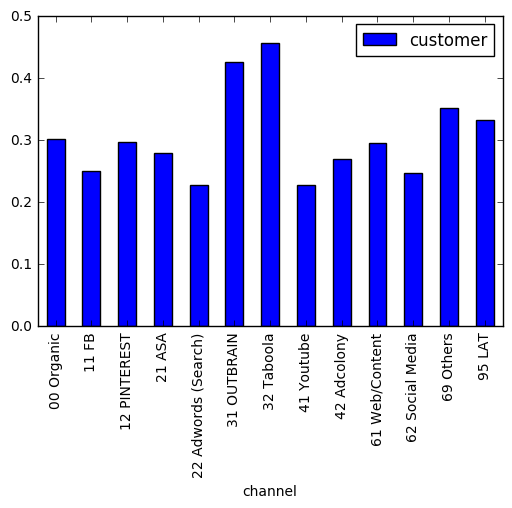

In [22]:
print(data.groupby('channel').size())

categorical_vs_predictor(data, 'channel', 'customer')

* Look at the age variable

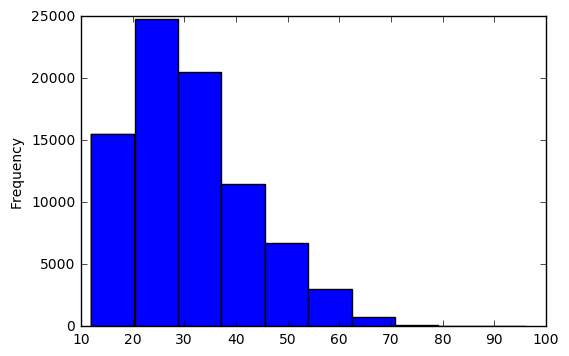

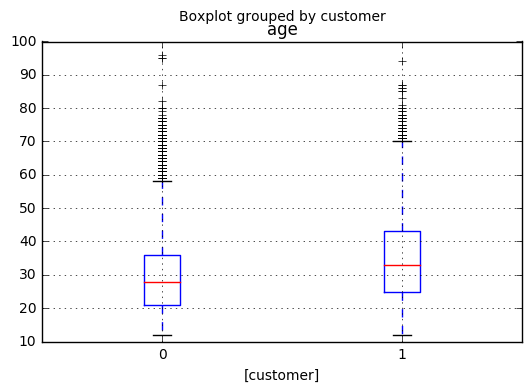

In [25]:
data['age'].plot(kind = 'hist')

numeric_vs_predictor(data, 'age', 'customer')

* Look at the os variable

os
android    34246
ios        48662
dtype: int64


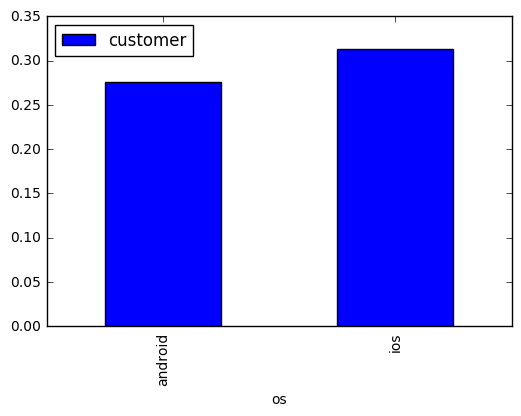

In [26]:
print(data.groupby('os').size())

categorical_vs_predictor(data, 'os', 'customer')

* Look at the gender variable

gender
female    57031
male      25877
dtype: int64


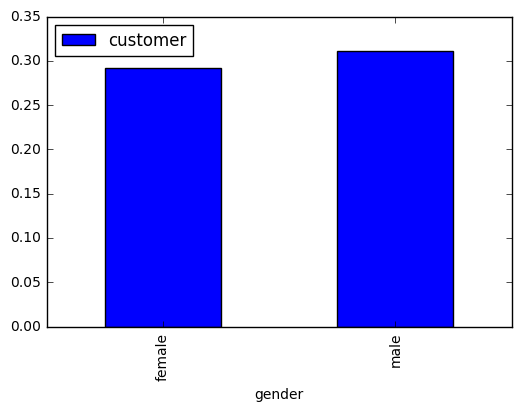

In [27]:
print(data.groupby('gender').size())

categorical_vs_predictor(data, 'gender', 'customer')

* Look at the country variable

country
AU     3398
CA     4483
DE     2849
ES     4172
FR     2170
GB     9226
MX     5755
US    50855
dtype: int64


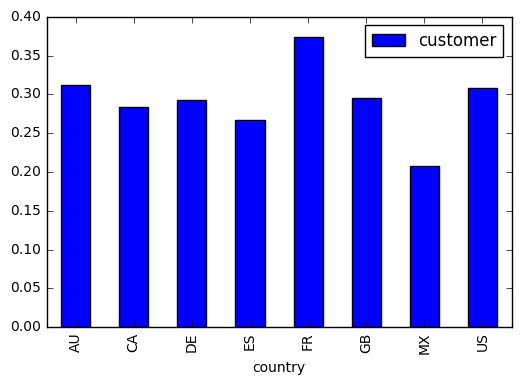

In [34]:
print(data.groupby('country').size())

categorical_vs_predictor(data, 'country', 'customer')

# 3. Modeling

* Set the categorical variables to be dummy variables

In [55]:
gender_map = {'female': 1, 'male': 0}
os_map = {'ios': 1, 'android': 0}
data['gender'] = data['gender'].map(gender_map)
data['os'] = data['os'].map(os_map)

data = pd.get_dummies(data)

* Split the data into testing & validation sets

In [120]:
y = data['customer']
X = data.drop(['customer', 'user_id'], axis = 1, inplace = False)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3)

* Oversample the training data to ensure class balance

In [121]:
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

* Fit a number of standard classification models to the data and see how they perform

Fitted model CART. AUC: 0.565787794252841, Misclassification rate: 0.37796003698789854
Fitted model RF. AUC: 0.5699465566153951, Misclassification rate: 0.387609053994291
Fitted model GBM. AUC: 0.6303748418289501, Misclassification rate: 0.3605113979013388
Fitted model KNN. AUC: 0.5711926798527731, Misclassification rate: 0.39971052948980823


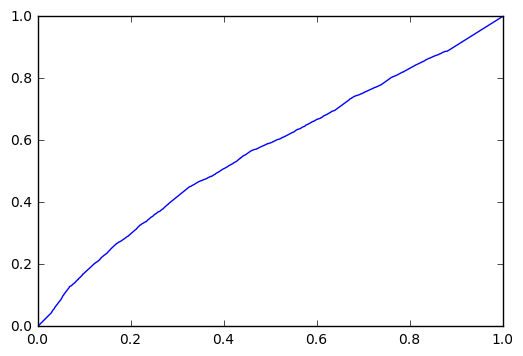

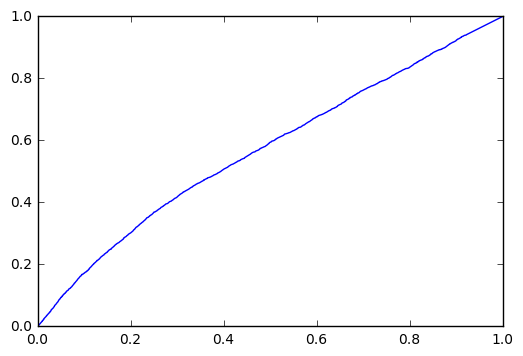

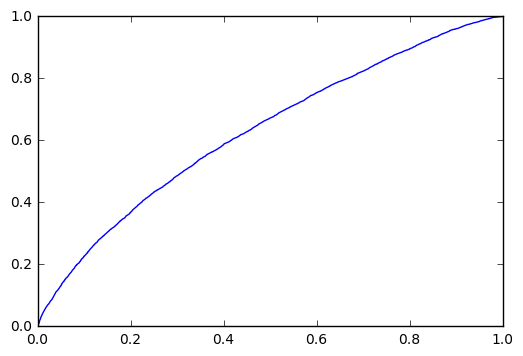

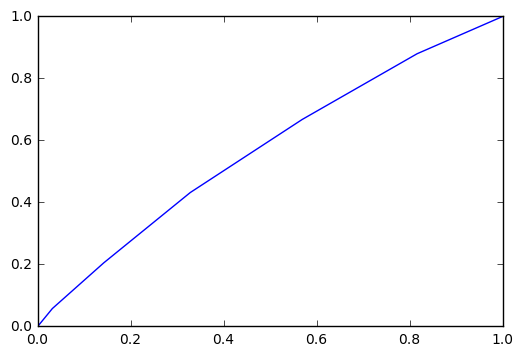

In [122]:
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('KNN', neighbors.KNeighborsClassifier()))


# evaluate each model in turn
results_in = []
names_in = []
for name, model in models:
    model.fit(X_train, y_train)
    predicted = model.predict_proba(X_validation)[:,1]
    misclass = sum(np.round(predicted) != y_validation)/len(y_validation)
    fpr, tpr, thresholds = roc_curve(y_validation, predicted)
    roc_auc = auc(fpr, tpr)
    print('Fitted model {0}. AUC: {1}, Misclassification rate: {2}'.format(name, roc_auc, misclass))
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    

* Do a random search to optimize the parameters for the Boosted Tree

In [130]:
gbm = GradientBoostingClassifier()

param_grid = {
              'n_estimators': scipy.stats.randint(3, 100),
              'learning_rate': scipy.stats.uniform(0.05, 0.4),
              'min_samples_split': scipy.stats.randint(2, 50),
              'max_depth': scipy.stats.randint(1, 12)
            }

gs = RandomizedSearchCV(gbm, param_grid, n_jobs=1, scoring = 'roc_auc', cv=5)  
gs.fit(X_train, y_train)  
print(gs.best_score_)
print(gs.best_params_)

0.718032978002
{'min_samples_split': 39, 'learning_rate': 0.35783898052295399, 'n_estimators': 88, 'max_depth': 6}


* Build the best model and plot the roc curve

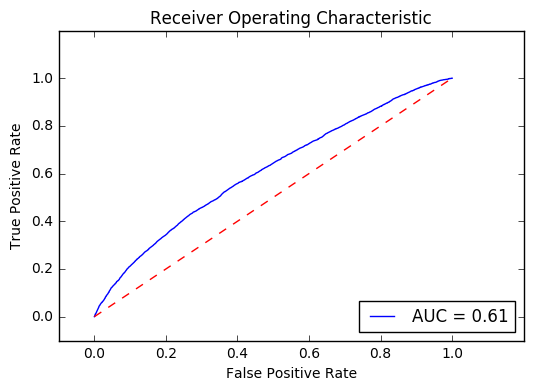

In [133]:
final_model = GradientBoostingClassifier(**gs.best_params_)
final_model.fit(X_train, y_train)

predicted = final_model.predict_proba(X_validation)[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, predicted)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 4. Predict the test data

* Read in the test data

In [137]:
test_data = pd.read_csv('./data/test_data.csv.csv_fixed')


print('Read in training data. Columns: {0}, Rows: {1}'.format(test_data.shape[1], test_data.shape[0]))

Read in training data. Columns: 6, Rows: 10000


* Set the categorical variables to be dummy variables

In [138]:
X_test = test_data

X_test['gender'] = X_test['gender'].map(gender_map)
X_test['os'] = X_test['os'].map(os_map)

X_test = pd.get_dummies(X_test)

* Remove the user_id

In [139]:
X_test = X_test.drop(['user_id'], axis = 1, inplace = False)

* Fit the model to the data

In [140]:
y_preds = final_model.predict(X_test)

* Output the predictions to csv

In [141]:
test_data['predictions'] = y_preds
test_data.to_csv('./conor_digan_predictions.csv')